# Setup libraries

In [1]:
!pip install --upgrade pip
!pip uninstall -y transformers tokenizers accelerate -q
!pip install "transformers==4.56.0" "protobuf==5.29.3" -q
!pip install torch datasets -q
!pip install pandas matplotlib seaborn tqdm wandb pyyaml
!pip install bitsandbytes accelerate
!pip install --force-reinstall --no-cache-dir "numpy<2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
peft 0.16.0 requires accelerate>=0.21.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 5.29.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich

# Config input/output path and clone latest repo

In [2]:
# Clone the latest github repo version
import os
def configure_environment_paths():
    """Detect environment and configure paths"""
    try:
        if "google.colab" in str(get_ipython()):
            print("✅ Environment: Google Colab")
            base_data_path = "/content/"
            base_output_path = "/content/output/"
            environment_name = "colab"
        elif os.environ.get("KAGGLE_KERNEL_RUN_TYPE"):
            print("✅ Environment: Kaggle")
            base_data_path = "/kaggle/input/"
            base_output_path = "/kaggle/working/"
            environment_name = "kaggle"
        else:
            print("⚠️ Environment: Local/Unknown")
            base_data_path = "./data/"
            base_output_path = "./output/"
            environment_name = "local"
    except NameError:
        print("⚠️ Non-interactive session. Using local paths.")
        base_data_path = "./data/"
        base_output_path = "./output/"
        environment_name = "local"

    os.makedirs(base_output_path, exist_ok=True)
    print(f"📂 Data Path: {base_data_path}")
    print(f"📦 Output Path: {base_output_path}")

    return base_data_path, base_output_path, environment_name

INPUT_PATH, OUTPUT_PATH, ENV_NAME = configure_environment_paths()

!rm -r -f OuroTrace
!git clone --branch claude https://github.com/dzungphieuluuky/OuroTrace.git
%cd OuroTrace

✅ Environment: Kaggle
📂 Data Path: /kaggle/input/
📦 Output Path: /kaggle/working/
Cloning into 'OuroTrace'...
remote: Enumerating objects: 534, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 534 (delta 150), reused 139 (delta 72), pack-reused 296 (from 1)
Receiving objects: 100% (534/534), 1.31 MiB | 9.97 MiB/s, done.
Resolving deltas: 100% (316/316), done.
/kaggle/working/OuroTrace


In [3]:
# Suppress warnings for clean output
import warnings
import os
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
print("✅ Packages installed successfully!")

✅ Packages installed successfully!


In [4]:
"Built-in libraries"
import re
import sys
import gc
import time
import json
import hashlib
import glob
import zipfile
from io import StringIO
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Any
import yaml
import logging
import random

"Deep learning and NLP libraries"
import torch
import torch.nn.functional as F
from transformers import (
    AutoConfig, 
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    GenerationConfig,
    logging as hf_logging
)

"Data processing libraries"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from tqdm.auto import tqdm
from IPython import get_ipython

# Configure logging
logging.getLogger("ContinuousBatchingLogger").setLevel(logging.ERROR)
hf_logging.set_verbosity_error()


print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
!nvidia-smi

Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
Tue Dec 16 10:30:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8             10W /   70W |       3MiB /  15360MiB |      0%      Default |
|   

In [5]:
import pandas as pd
from src.config_loader import load_config_from_json, post_process_config
from src.runner import run_batch_experiment
from src.evaluation import analyze_experiment_results


# 1. Load Configuration from JSON
config = load_config_from_json('configs/batch_ouro_1.4b_thinking.json')

# 2. Post-process (Convert 'torch.float16' string to object, generate timestamps)
config = post_process_config(config)

config["INFERENCE_STEPS"] = [1]
# config['MODEL']['dtype'] = torch.bfloat16
# config['OPTIMIZATION']['max_batch_size'] = 1
config["reasoning_primitives"]["num_samples"] = 5

# 4. Execute
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"🕒 Timestamp: {timestamp}")
print("🚀 Starting Experiment...")
acc_results, ppl_results, hol_results = run_batch_experiment(config)

🕒 Timestamp: 20251216_103020
🚀 Starting Experiment...
🔗 Initializing W&B (timeout: 30s)...
⚠️ W&B initialization failed: 1 validation error for Settings
start_timeout
  Extra inputs are not permitted [type=extra_forbidden, input_value=30, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden. Continuing offline.

🔧 EXPERIMENT CONFIGURATION
Model Path: ByteDance/Ouro-1.4B-Thinking
UT Steps to Test: [1]
Data Type: torch.bfloat16
4-bit Quantization: False
Torch Compile: True
Max Batch Size: 8
Max New Tokens: 512
Enable Batching: True
Calculate Perplexity: True
Early Exit Threshold: 1.0

🎲 Random seed set to 42

📦 LOADING TEST DATASETS
⚙️ Generating new test datasets...
✅ Generated test datasets

Dataset Summary:
   n_ary       :   24 samples
   p_hop       :   24 samples
   igsm        :    8 samples

📚 Preparing perplexity evaluation data...
✅ Prepared 50 samples for PPL


🧪 EXPERIMENT 1/1: UT Steps = 1


⚙️  LOADING MODEL CONFIGURATION
Mode

config.json: 0.00B [00:00, ?B/s]

configuration_ouro.py: 0.00B [00:00, ?B/s]


→ Base config loaded
   Original UT steps: 4
   Original early exit: 1.0

→ Modified config:
   New UT steps: 1
   New early exit: 1.0


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]


→ Tokenizer loaded
   Vocab size: 49152
   PAD token: <|im_end|>
   EOS token: <|im_end|>

→ Loading model weights...


modeling_ouro.py: 0.00B [00:00, ?B/s]

2025-12-16 10:30:24.861709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765881025.080143      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765881025.129263      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

→ Applying torch.compile()

✅ MODEL LOADED SUCCESSFULLY
Device: cuda:0
Model dtype: torch.bfloat16
VERIFIED UT steps: 1
VERIFIED early exit: 1.0

🔧 Building task templates...
[+] Task templates pre-computed (Corrected with Step Prefixes and Guardrails)

📉 PERPLEXITY EVALUATION



Calculating PPL (UT=1):   0%|          | 0/8 [00:00<?, ?it/s]

W1216 10:31:28.409000 47 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode



✅ Perplexity Results:
   Perplexity: 8.3812
   Avg Loss:   2.1260

🎯 ACCURACY EVALUATION


──────────────────────────────────────────────────────────────────────
📝 Task: N_ARY
──────────────────────────────────────────────────────────────────────
Total Samples: 24
Batch Size: 8
Strategy: Batched Processing

Running 3 batches...


   n_ary:   0%|          | 0/3 [00:00<?, ?it/s]


Solving 8 requests: 100%|██████████| 8/8 [00:09<00:00,  1.18s/request]


             test_input                                      full_response expected_answer prediction  is_correct
355 + 929 + 970 + 766 = \n[1]  1000\n[2] 1000+929=1929\n[3] 1929+970=29...            3020       4731       False
             test_input                                      full_response expected_answer prediction  is_correct
435 + 993 + 431 + 924 = \n[1]  1000\n[2] 1000+993=1993\n[3] 1993+431=24...            2783       3348       False
             test_input                                      full_response expected_answer prediction  is_correct
182 + 055 + 078 + 498 = \n[1]  0\n[2] 0+182=182\n[3] 182+055=237\n[4] 2...             813        813        True
             test_input                                      full_response expected_answer prediction  is_correct
164 + 341 + 698 + 726 = \n[1]  164+341=405\n[2] 405+698=1103\n[3] 1103+...            1929       1993       False
             test_input                                      full_response expected_answ


Solving 8 requests: 100%|██████████| 8/8 [01:00<00:00,  7.61s/request]


                                     test_input                                      full_response expected_answer prediction  is_correct
093 + 938 + 014 + 896 + 993 + 798 + 996 + 431 = \n[1]  0\n[2] 0+10=10\n[3] 10+20=30\n[4] 30+30=...            5159      17194       False
                                     test_input                                      full_response expected_answer prediction  is_correct
879 + 671 + 594 + 500 + 665 + 779 + 368 + 012 = \n[1]  0\n[2] 0+10=10\n[3] 10+20=30\n[4] 30+30=...            4468       7653       False
                                     test_input                                      full_response expected_answer prediction  is_correct
341 + 603 + 048 + 632 + 058 + 708 + 277 + 385 = \n[1]  0\n[2] 0+10=10\n[3] 10+20=30\n[4] 30+30=...            3052          8       False
                                     test_input                                      full_response expected_answer prediction  is_correct
261 + 441 + 386 + 418 + 965 + 909 


Solving 8 requests: 100%|██████████| 8/8 [01:10<00:00,  8.77s/request]

⚠️ GARBAGE OUTPUT detected in batch for n_ary (idx=7)
                                        test_input                                      full_response expected_answer prediction  is_correct
075 + 757 + 658 + 491 + 419 + 057 + 469 + 402 +... \n[1]  1000\n[2] 1000+1000=2000\n[3] 2000+2000=...            6876      ERROR       False
                                        test_input                                      full_response expected_answer prediction  is_correct
740 + 650 + 770 + 288 + 519 + 601 + 513 + 603 +... \n[1]  0\n[2] 0+10=10\n[3] 10+20=30\n[4] 30+30=...            7984        156       False
                                        test_input                                      full_response expected_answer prediction  is_correct
384 + 724 + 510 + 442 + 566 + 092 + 256 + 833 +... \n[1]  1000\n[2] 1000+000=1000\n[3] 1000+000=10...            7231       1000       False
                                        test_input                                      full_respons

   p_hop:   0%|          | 0/6 [00:00<?, ?it/s]


Solving 4 requests: 100%|██████████| 4/4 [00:03<00:00,  1.10request/s]


                                        test_input     full_response expected_answer prediction  is_correct
Sequence: DDADDDDCBDACABBACCACDBACABCCDCCDCBCCC... \n[T]  A→B\n[F] B               D          B       False
                                        test_input                     full_response expected_answer prediction  is_correct
Sequence: BBCDBCABCBBAAAADACADADAAACDBCCBBACBBB... \n[T]  A→B\n[F] B\n[T] A→B\n[F] B               C          B       False
                                        test_input                     full_response expected_answer prediction  is_correct
Sequence: AADBCDCADAABACCCCADDADABBDCDBBCDCCABC... \n[T]  A→B\n[F] B\n[T] A→B\n[F] B               D          B       False
                                        test_input     full_response expected_answer prediction  is_correct
Sequence: CBDDAACACDBDBCBCDABADBCACCDDDDCCAACAD... \n[T]  A→B\n[F] B               A          B       False



Solving 4 requests: 100%|██████████| 4/4 [01:02<00:00, 15.58s/request]


⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=3)
                                        test_input                                      full_response expected_answer prediction  is_correct
Sequence: BCCCBADBDCDCCBDBBDDBCADDBBCCAADBCDCBC... \n[T]  A→B\n[F] B→C\n[T] A→B\n[F] B→C\n[T] A→B\...               B          B        True
                                        test_input                                      full_response expected_answer prediction  is_correct
Sequence: BABCDADBDDDACAABDAADDBCADDCBDAACACBBD... \n[T]  A→B\n[F] B→C\n[T] A→B\n[F] B→C\n[T] A→B\...               C          B       False
                                        test_input                                      full_response expected_answer prediction  is_correct
Sequence: BACBDBDBCBDBBBCBCACADDBBBCADABDCCCABC... \n[T]  A→B\n[F] B→C\n[T] A→B\n[F] B→C\n[T] A→B\...               B          B        True
                                        test_input                                      full_respons


Solving 4 requests: 100%|██████████| 4/4 [00:55<00:00, 13.92s/request]


⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=0)
⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=2)
                                        test_input                                      full_response expected_answer prediction  is_correct
Sequence: DBBBBACADDAABBACBCBDCDDDBCDBDBBCDCBDB... \n[T]  A→B\n[F] B\n[T] A→B\n[F] B\n[T] A→B\n[F]...               C DEGENERATE       False
                                        test_input     full_response expected_answer prediction  is_correct
Sequence: BCCACCACACCDCDDBDDADABDDAABBACBCACBAA... \n[T]  A→B\n[F] B               D          B       False
                                        test_input                                      full_response expected_answer prediction  is_correct
Sequence: DCDCBACACDAAACCAADACBBDDBDCCABBCBBBCA... \n[T]  A→B\n[F] B\n[T] A→B\n[F] B\n[T] A→B\n[F]...               B DEGENERATE       False
                                        test_input                     full_response expected_answer prediction 


Solving 4 requests: 100%|██████████| 4/4 [00:55<00:00, 13.92s/request]


⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=0)
⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=1)
                                        test_input                                      full_response expected_answer prediction  is_correct
Sequence: AABADBADADACDCDAABBBBADDDDDCAAADAABBA... \n[T]  A→B\n[F] B\n[T] A→B\n[F] B\n[T] A→B\n[F]...               A DEGENERATE       False
                                        test_input                                      full_response expected_answer prediction  is_correct
Sequence: DABCCABAABCADDBDBBBABABCCCDCACAADBBAD... \n[T]  A→B\n[F] B\n[T] A→B\n[F] B\n[T] A→B\n[F]...               C DEGENERATE       False
                                        test_input     full_response expected_answer prediction  is_correct
Sequence: BCBBCDDCCBDBAACCDDAAABCACADDBDABDCCAB... \n[T]  A→B\n[F] B               A          B       False
                                        test_input                     full_response expected_answer prediction 


Solving 4 requests: 100%|██████████| 4/4 [00:23<00:00,  5.88s/request]


⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=1)
                                        test_input     full_response expected_answer prediction  is_correct
Sequence: AACDBDBCDCAACACBABDBDDBBDABDCDDACADBA... \n[T]  A→B\n[F] B               B          B        True
                                        test_input                                      full_response expected_answer prediction  is_correct
Sequence: BBAACBBACDADDBDBCDDCACCADDADBBCDDABCA... \n[T]  A→B\n[F] B\n[T] A→B\n[F] B\n[T] A→B\n[F]...               D DEGENERATE       False
                                        test_input     full_response expected_answer prediction  is_correct
Sequence: CDBBBADDACAADBBACDDDBCACCDABADDABACAD... \n[T]  A→B\n[F] B               A          B       False
                                        test_input     full_response expected_answer prediction  is_correct
Sequence: ADADACADBBDDBBCBDCCBDBDDBBACDADBBBBCC... \n[T]  A→B\n[F] B               B          B        True



Solving 4 requests: 100%|██████████| 4/4 [00:23<00:00,  5.90s/request]

⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=0)
                                        test_input                                      full_response expected_answer prediction  is_correct
Sequence: DDCABADDCACCBDBCCABCDADDBCDADCBBDBADB... \n[T]  A→B\n[F] B\n[T] A→B\n[F] B\n[T] A→B\n[F]...               C DEGENERATE       False
                                        test_input     full_response expected_answer prediction  is_correct
Sequence: ADACCACDACBABABCBDACCDDDBADCBBDCCCDDD... \n[T]  A→B\n[F] B               A          B       False
                                        test_input     full_response expected_answer prediction  is_correct
Sequence: ADDDACACBBABBCDDADCBAACBADCCCDDAACDBD... \n[T]  A→B\n[F] B               D          B       False
                                        test_input     full_response expected_answer prediction  is_correct
Sequence: BCBCDDDBBCBBDDBBCDDBCBDCBADDBBACDABAA... \n[T]  A→B\n[F] B               B          B        True

───────────────

   igsm:   0%|          | 0/4 [00:00<?, ?it/s]


Solving 2 requests: 100%|██████████| 2/2 [00:04<00:00,  2.07s/request]


⚠️ GARBAGE OUTPUT detected in batch for igsm (idx=0)
                                        test_input                        full_response expected_answer prediction  is_correct
Question. O#H := O#C + P#D. H#H := F#F. N#O := ... \n[1]  1\n[2] 0\n[3] 0\n[4] 0\n[5] 0               2 DEGENERATE       False
                                        test_input                                  full_response expected_answer prediction  is_correct
Question. H#B := 4. E#K := 4. G#L := 5. C#O := ... \n[1]  = 4\n[2] = 4\n[3] = 4\n[4] = 1\n[5] = 1               3          1       False



Solving 2 requests: 100%|██████████| 2/2 [00:05<00:00,  2.88s/request]


                                        test_input                                      full_response expected_answer prediction  is_correct
Question. L#M := O#J. D#E := I#I - O#O. O#P := ... \n[1]  1.\n[2] 2.\n[3] 3.\n[4] 4.\n[5] 5.\n[6] ...               0          7       False
                                        test_input                                      full_response expected_answer prediction  is_correct
Question. A#D := 1. C#B := 6. F#O := E#L. I#B :... \n[1]  = 1\n[2] = 6\n[3] = 6\n[4] = 1\n[5] = 1\...               4          1       False



Solving 2 requests: 100%|██████████| 2/2 [00:04<00:00,  2.04s/request]


⚠️ GARBAGE OUTPUT detected in batch for igsm (idx=1)
                                        test_input                                  full_response expected_answer prediction  is_correct
Question. L#M := G#J. L#D := E#A. L#O := L#M. N... \n[1]  = 1\n[2] = 1\n[3] = 1\n[4] = 1\n[5] = 1               4          1       False
                                        test_input                        full_response expected_answer prediction  is_correct
Question. A#A := 1. K#P := 1. H#O := J#M - H#B.... \n[1]  1\n[2] 1\n[3] 1\n[4] 1\n[5] 1               0 DEGENERATE       False



Solving 2 requests: 100%|██████████| 2/2 [00:25<00:00, 12.54s/request]

                                        test_input                                      full_response expected_answer prediction  is_correct
Question. F#M := 0. J#I := F#O - F#O. M#J := 2.... \n[1]  = 0\n[2] = 1\n[3] = 2\n[4] = 3\n[5] = 4\...               4         60       False
                                        test_input                                      full_response expected_answer prediction  is_correct
Question. A#J := 3. H#L := 3. F#E := B#G. E#D :... \n[1]  = 3\n[2] = 3\n[3] = 0\n[4] = 0\n[5] = 0\...               0          0        True

──────────────────────────────────────────────────────────────────────
📊 Summary for IGSM
──────────────────────────────────────────────────────────────────────
Accuracy:             12.50% (1/8)
Garbage Outputs:          2 (25.0%)
Avg Gen Time:         4.921s
Avg Tokens:            96.5
Total Duration:        39.4s
Throughput:            0.20 samples/sec
──────────────────────────────────────────────────────────────────────

📋 Det

var_assign_depth_0_code:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_0_math (5 samples)


var_assign_depth_0_math:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_0_equation (5 samples)


var_assign_depth_0_equation:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_1_code (5 samples)


var_assign_depth_1_code:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_1_math (5 samples)


var_assign_depth_1_math:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_1_equation (5 samples)


var_assign_depth_1_equation:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%

📚 Running Standard Benchmarks (lm-eval)
⚠️ 'lm-evaluation-harness' not installed. Skipping Standard Benchmarks.
ℹ️ To run: pip install lm-evaluation-harness
⚠️ Holistic evaluation failed: list indices must be integers or slices, not str

🧹 Cleaning up GPU memory...
✅ GPU memory freed


📊 FINAL EXPERIMENT SUMMARY

⚠️ WARNING: 10 garbage/degenerate outputs detected

📈 Overall Accuracy by Task Type:
──────────────────────────────────────────────────────────────────────
          Accuracy   N
task_type             
igsm        12.50%   8
n_ary        4.17%  24
p_hop       20.83%  24

📈 Accuracy by UT Steps:
──────────────────────────────────────────────────────────────────────
         Accuracy   N
ut_steps             
1          12.50%  56

📈 Accuracy by Task Type and UT Steps:
──────────────────────────────────────────────────────────────────────
ut_steps       1
task_type       
igsm       12.50
n_ary       4.17
p_hop      20.83

📉 Perplexity by UT Steps:
───────


💾 Results saved to /kaggle/working/

📊 VISUALIZATION

--- Summary Statistics ---
                    is_correct_mean  is_correct_count  is_correct_std  \
ut_steps task_type                                                      
1        igsm                 0.125                 8           0.354   
         n_ary                0.042                24           0.204   
         p_hop                0.208                24           0.415   

                    generation_time_mean  generation_time_min  \
ut_steps task_type                                              
1        igsm                      4.921                2.071   
         n_ary                     5.869                1.193   
         p_hop                     9.380                0.940   

                    generation_time_max  generated_tokens_mean  
ut_steps task_type                                              
1        igsm                    12.570                 96.500  
         n_ary                 

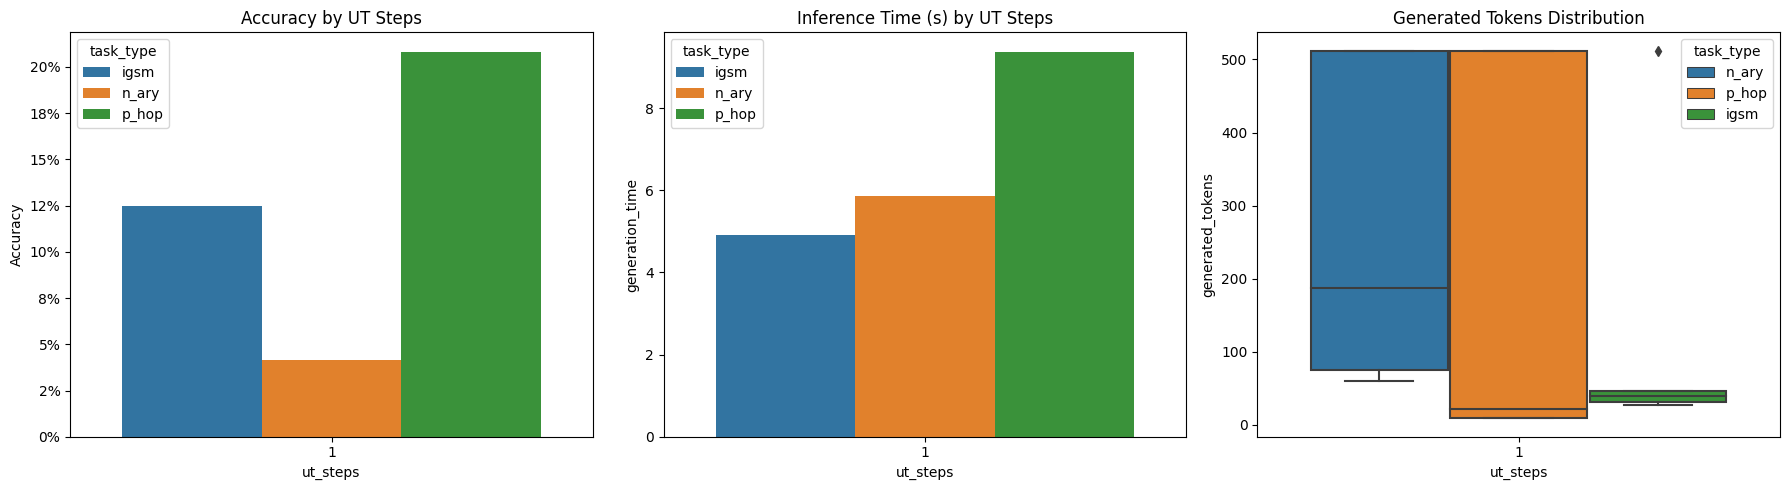


🏁 Experiment Complete.



In [6]:
# 3. Save Results
df_acc = pd.DataFrame(acc_results)
df_ppl = pd.DataFrame(ppl_results)
df_hol = pd.DataFrame(hol_results)
RUN_RESULTS_NAME = f"run_{timestamp}"
os.makedirs(os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME), exist_ok=True)
acc_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_acc_{timestamp}.csv")
ppl_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_ppl_{timestamp}.csv")
hol_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_hol_{timestamp}.csv")
cfg_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_config_{timestamp}.yaml")

df_acc.to_csv(acc_path, index=False)
if not df_ppl.empty:
    df_ppl.to_csv(ppl_path, index=False)
if not df_hol.empty:
    df_hol.to_csv(hol_path, index=False)
# Save Config
def sanitize_config(cfg):
    """Convert config to YAML-safe format"""
    clean = {}
    for k, v in cfg.items():
        if isinstance(v, dict):
            clean[k] = sanitize_config(v)
        elif str(type(v)).find('torch.') != -1:
            clean[k] = str(v)
        else:
            clean[k] = v
    return clean

with open(cfg_path, 'w') as f:
    yaml.dump(sanitize_config(config), f)

print(f"\n💾 Results saved to {OUTPUT_PATH}")

# 4. Visualization & Reporting
if not df_acc.empty:
    print("\n" + "="*50 + "\n📊 VISUALIZATION\n" + "="*50)
    
    # Summary Tables
    # NOTE: The variable 'results_acc' is used here, assuming it holds the raw data 
    # (list of dicts) required by 'analyze_experiment_results'.
    summary = analyze_experiment_results(acc_results)
    print("\n--- Summary Statistics ---")
    print(summary)
    
    # Plotting
    try:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot 1: Accuracy
        acc_summary = df_acc.groupby(['task_type', 'ut_steps'])['is_correct'].mean().reset_index()
        sns.barplot(data=acc_summary, x='ut_steps', y='is_correct', hue='task_type', ax=axes[0])
        axes[0].set_title('Accuracy by UT Steps')
        axes[0].set_ylabel('Accuracy')
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        # Plot 2: Time
        time_summary = df_acc.groupby(['task_type', 'ut_steps'])['generation_time'].mean().reset_index()
        sns.barplot(data=time_summary, x='ut_steps', y='generation_time', hue='task_type', ax=axes[1])
        axes[1].set_title('Inference Time (s) by UT Steps')
        
        # Plot 3: Token Count
        sns.boxplot(data=df_acc, x='ut_steps', y='generated_tokens', hue='task_type', ax=axes[2])
        axes[2].set_title('Generated Tokens Distribution')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Visualization error: {e}")
else:
    print("⚠️ No results to visualize.")

print("\n🏁 Experiment Complete.\n")

In [7]:
import os
import glob
import zipfile

def zip_all_run_folders(output_base_path: str):
    os.makedirs(output_base_path, exist_ok=True)
    
    search_pattern = os.path.join(output_base_path, "run_*")
    run_folders = glob.glob(search_pattern)
    run_directories = [d for d in run_folders if os.path.isdir(d)]

    if not run_directories:
        print(f"⚠️ Không tìm thấy thư mục nào bắt đầu bằng 'run_' trong '{output_base_path}'.")
        return

    print(f"🔍 Tìm thấy {len(run_directories)} thư mục kết quả để nén.")
    
    successful_zips = 0

    for folder_path in run_directories:
        folder_name = os.path.basename(folder_path)
        zip_filename = os.path.join(output_base_path, f"{folder_name}.zip")
        
        try:
            print(f"\n   -> Đang nén thư mục: {folder_name}...")
            
            with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
                for root, _, files in os.walk(folder_path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                        zipf.write(file_path, arcname)
                        
            print(f"   ✅ Đã tạo file ZIP: {os.path.basename(zip_filename)}")
            successful_zips += 1
            
        except Exception as e:
            print(f"   ❌ Lỗi khi nén thư mục {folder_name}: {e}")

    print(f"\n✅ HOÀN TẤT! Đã nén thành công {successful_zips} trên {len(run_directories)} thư mục kết quả.")


try:
    if 'OUTPUT_PATH' in globals():
        zip_all_run_folders(OUTPUT_PATH)
    else:
        print("OUTPUT_PATH not defined.")
        
except NameError:
    print("OUTPUT_PATH not defined.")
except Exception as e:
    print(f"Đã xảy ra lỗi trong quá trình nén: {e}")

🔍 Tìm thấy 1 thư mục kết quả để nén.

   -> Đang nén thư mục: run_20251216_103020...
   ✅ Đã tạo file ZIP: run_20251216_103020.zip

✅ HOÀN TẤT! Đã nén thành công 1 trên 1 thư mục kết quả.


In [8]:
print("Final Inspection:\n")
print("Top 20 Accuracy Report:\n")
print(df_acc.head(20))
print(f"Full Response:\n")
print(df_acc['full_response'])
print("Perplexity Report:\n")
print(df_ppl.head(20))

Final Inspection:

Top 20 Accuracy Report:

   task_type difficulty                                         test_input  \
0      n_ary      4_ops                            355 + 929 + 970 + 766 =   
1      n_ary      4_ops                            435 + 993 + 431 + 924 =   
2      n_ary      4_ops                            182 + 055 + 078 + 498 =   
3      n_ary      4_ops                            164 + 341 + 698 + 726 =   
4      n_ary      4_ops                            985 + 445 + 350 + 251 =   
5      n_ary      4_ops                            267 + 937 + 722 + 841 =   
6      n_ary      4_ops                            607 + 728 + 166 + 883 =   
7      n_ary      4_ops                            347 + 833 + 940 + 890 =   
8      n_ary      8_ops    093 + 938 + 014 + 896 + 993 + 798 + 996 + 431 =   
9      n_ary      8_ops    879 + 671 + 594 + 500 + 665 + 779 + 368 + 012 =   
10     n_ary      8_ops    341 + 603 + 048 + 632 + 058 + 708 + 277 + 385 =   
11     n_ary      8_

In [9]:
print(df_acc[['full_response', 'generated_tokens']])

                                        full_response  generated_tokens
0   \n[1]  1000\n[2] 1000+929=1929\n[3] 1929+970=2...                79
1   \n[1]  1000\n[2] 1000+993=1993\n[3] 1993+431=2...                69
2   \n[1]  0\n[2] 0+182=182\n[3] 182+055=237\n[4] ...                65
3   \n[1]  164+341=405\n[2] 405+698=1103\n[3] 1103...                66
4   \n[1]  1000\n[2] 1000+445=1445\n[3] 1445+350=1...                69
5   \n[1]  267+937=1204\n[2] 1204+722=1926\n[3] 19...                68
6   \n[1]  1300\n[2] 1300+728=2028\n[3] 2028+166=2...                60
7   \n[1]  1200\n[2] 1200+833=2033\n[3] 2033+940=3...                79
8   \n[1]  0\n[2] 0+10=10\n[3] 10+20=30\n[4] 30+30...               512
9   \n[1]  0\n[2] 0+10=10\n[3] 10+20=30\n[4] 30+30...               317
10  \n[1]  0\n[2] 0+10=10\n[3] 10+20=30\n[4] 30+30...               512
11  \n[1]  1000\n[2] 1000+441=541\n[3] 541+386=927...               165
12  \n[1]  0\n[2] 0+10=10\n[3] 10+20=30\n[4] 30+30...           